# Validate embeddings

In [2]:
%load_ext autoreload
%autoreload 2
%cd '/home/afischer/snakeclef-2024'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from snakeclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/08 20:52:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/08 20:52:50 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


### embeddings

In [13]:
# Get list of stored filed in cloud bucket
root = "gs://dsgt-clef-snakeclef-2024"
! date
! gcloud storage ls {root}/data/process/

Wed May  8 20:53:34 UTC 2024


/snap/google-cloud-cli/215/lib/third_party/urllib3/connectionpool.py:1060: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/snap/google-cloud-cli/215/lib/third_party/urllib3/connectionpool.py:1060: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/snap/google-cloud-cli/215/lib/third_party/urllib3/connectionpool.py:1060: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
gs://dsgt-clef-snakeclef-2024/data/pr

In [14]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-snakeclef-2024/data/parquet_files/"
train = "SnakeCLEF2023-train-small_size"

# Define the GCS path to the Train parquet file
train_gcs_path = f"{gcs_path}{train}"

# Read the Parquet file into a DataFrame
train_df = spark.read.parquet(train_gcs_path)

# Show the data
train_df.show(n=5)

+--------------------+--------------------+--------------------+----+--------------------+-------------+--------------------+--------------+-------+----+--------+------+
|          image_path|                path|         folder_name|year|       binomial_name|    file_name|                data|observation_id|endemic|code|class_id|subset|
+--------------------+--------------------+--------------------+----+--------------------+-------------+--------------------+--------------+-------+----+--------+------+
|1993/Phrynonax_po...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|1993| Phrynonax_polylepis|102870166.jpg|[FF D8 FF E0 00 1...|      64030606|  false|  EC|    1287| train|
|1995/Acrantophis_...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|1995|Acrantophis_dumerili| 99694826.jpg|[FF D8 FF E0 00 1...|      62240606|   true|  MG|      11| train|
|1996/Ficimia_stre...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|1996|   Ficimia_streckeri| 29265846.jpg|[FF D8 FF E0 00 1...|       2442697|  false|  

### subset training data

In [17]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-snakeclef-2024/data/process"
dino_emb_train = "subset_training_small_v1/dino/data"
dct_emb_train = "subset_training_small_v1/dino_dct/data"

# Previous embeddings
gcs_prevembeddings_path = "gs://dsgt-clef-snakeclef-2024/data/parquet_files/DINOv2-embeddings-large_size"

# Define the GCS path to the embedding files
dino_gcs_path = f"{gcs_path}/{dino_emb_train}"
dct_gcs_path = f"{gcs_path}/{dct_emb_train}"

# Read the Parquet file into a DataFrame
dino_df = spark.read.parquet(dino_gcs_path)
dct_df = spark.read.parquet(dct_gcs_path)
dinoprev_df = spark.read.parquet(gcs_prevembeddings_path)


# Show the data
dino_df.show(n=5, truncate=50)
dct_df.show(n=5, truncate=50)
dinoprev_df.show(n=5, truncate=50)

+--------------------------------------------------+--------------+--------------------------------------------------+
|                                              path|observation_id|                                    dino_embedding|
+--------------------------------------------------+--------------+--------------------------------------------------+
|/SnakeCLEF2023-small_size/2009/Bothriechis_schl...|       5156122|[3.3206954, 1.7568659, 0.9993968, -0.4818493, -...|
|/SnakeCLEF2023-small_size/2009/Bothriechis_schl...|       5156122|[4.5297003, 1.111089, 0.25359935, -0.30571687, ...|
|/SnakeCLEF2023-small_size/2009/Bothriechis_schl...|       5156122|[1.9901332, 2.010803, -0.7306451, -0.8257254, 1...|
|/SnakeCLEF2023-small_size/2009/Bothriechis_schl...|       5156122|[2.4793103, 1.47692, 0.6700275, -0.47778895, 0....|
|/SnakeCLEF2023-small_size/2009/Bothriechis_schl...|       5156122|[1.3712707, 2.4690998, -0.9308273, -0.48359674,...|
+-----------------------------------------------

+--------------------------------------------------+--------------+--------------------------------------------------+
|                                              path|observation_id|                                     dct_embedding|
+--------------------------------------------------+--------------+--------------------------------------------------+
|/SnakeCLEF2023-small_size/2009/Bothriechis_schl...|       5156122|[-14821.599, 13906.393, 8030.675, -8279.041, -7...|
|/SnakeCLEF2023-small_size/2009/Bothriechis_schl...|       5156122|[-18731.363, -3099.667, -3945.6943, -26477.107,...|
|/SnakeCLEF2023-small_size/2009/Bothriechis_schl...|       5156122|[-22501.023, -5693.7183, 10794.748, -31486.793,...|
|/SnakeCLEF2023-small_size/2009/Bothriechis_schl...|       5156122|[-24802.61, 14391.339, -23153.145, -29816.785, ...|
|/SnakeCLEF2023-small_size/2009/Bothriechis_schl...|       5156122|[-21237.771, 125.101074, 3472.2505, -31750.246,...|
+-----------------------------------------------

+----------------------------------------------+--------------------------------------------------+------------------------+----+---------------------------+-------------+--------------+-------+-------+--------+------+--------------------------------------------------+
|                                    image_path|                                              path|             folder_name|year|              binomial_name|    file_name|observation_id|endemic|   code|class_id|subset|                                    dino_embedding|
+----------------------------------------------+--------------------------------------------------+------------------------+----+---------------------------+-------------+--------------+-------+-------+--------+------+--------------------------------------------------+
|    1997/Xerotyphlops_vermicularis/2992029.jpg|/SnakeCLEF2023-large_size/1997/Xerotyphlops_ver...|SnakeCLEF2023-large_size|1997|  Xerotyphlops_vermicularis|  2992029.jpg|        522546|  fa

In [18]:
# Join with dino_df with train_df to get species names
dino_joined_df = dino_df.join(train_df, "path", "inner").select(
    [
        dino_df["path"],
        train_df["binomial_name"],
        dino_df["observation_id"],
        dino_df["dino_embedding"],
    ]
)
dino_joined_df.show(n=5)

# Join dct_df with train_df to get species names
dct_joined_df = dct_df.join(train_df, "path", "inner").select(
    [
        dct_df["path"],
        train_df["binomial_name"],
        dct_df["observation_id"],
        dct_df["dct_embedding"],
    ]
)

+--------------------+--------------------+--------------+--------------------+
|                path|       binomial_name|observation_id|      dino_embedding|
+--------------------+--------------------+--------------+--------------------+
|/SnakeCLEF2023-sm...|Bothriechis_schle...|       5156122|[0.7049255, 1.525...|
|/SnakeCLEF2023-sm...|Bothriechis_schle...|       5156122|[0.6571303, 1.830...|
|/SnakeCLEF2023-sm...|Bothriechis_schle...|       5156122|[1.7149277, -0.57...|
|/SnakeCLEF2023-sm...|Bothriechis_schle...|       5156122|[0.34934857, 2.08...|
|/SnakeCLEF2023-sm...|Bothriechis_schle...|       5156122|[4.5297003, 1.111...|
+--------------------+--------------------+--------------+--------------------+
only showing top 5 rows



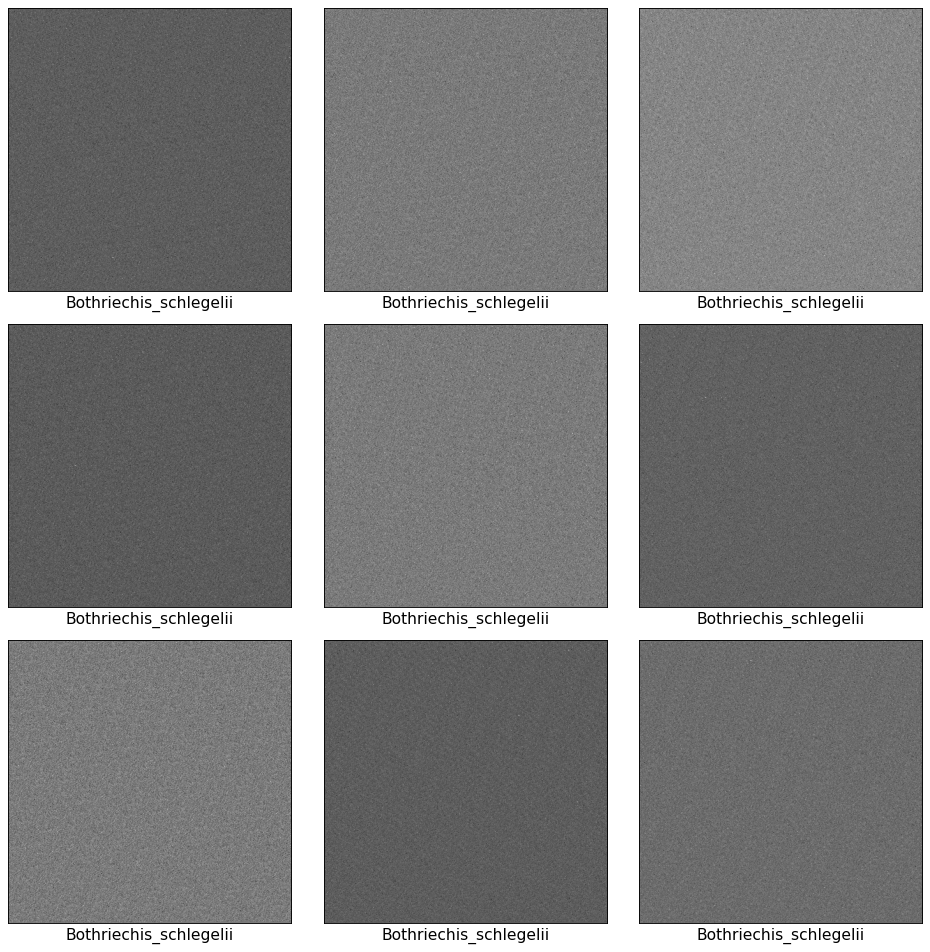

In [19]:
from snakeclef.plotting import plot_images_from_embeddings

# Plot DINO image embeddings
plot_images_from_embeddings(
    dino_joined_df, data_col="dino_embedding", image_col="binomial_name", grid_size=(3, 3)
)

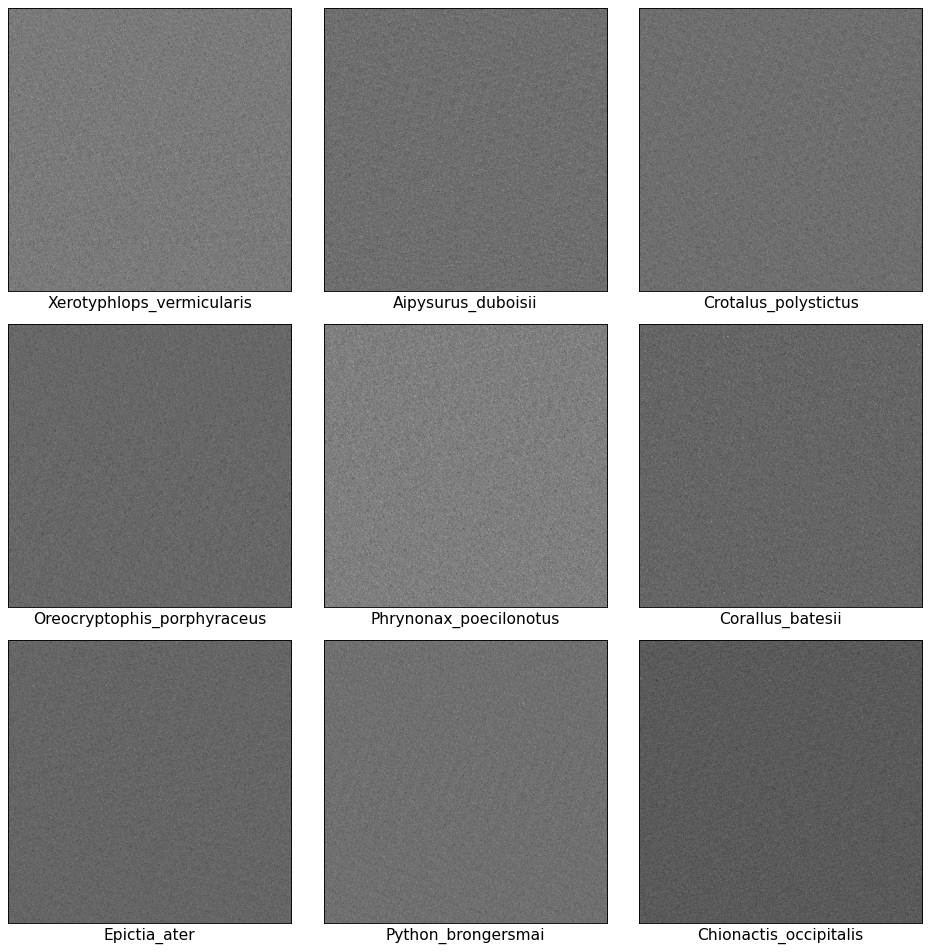

In [20]:
# Plot DINO image embeddings from previous transformations
plot_images_from_embeddings(
    dinoprev_df, data_col="dino_embedding", image_col="binomial_name", grid_size=(3, 3)
)

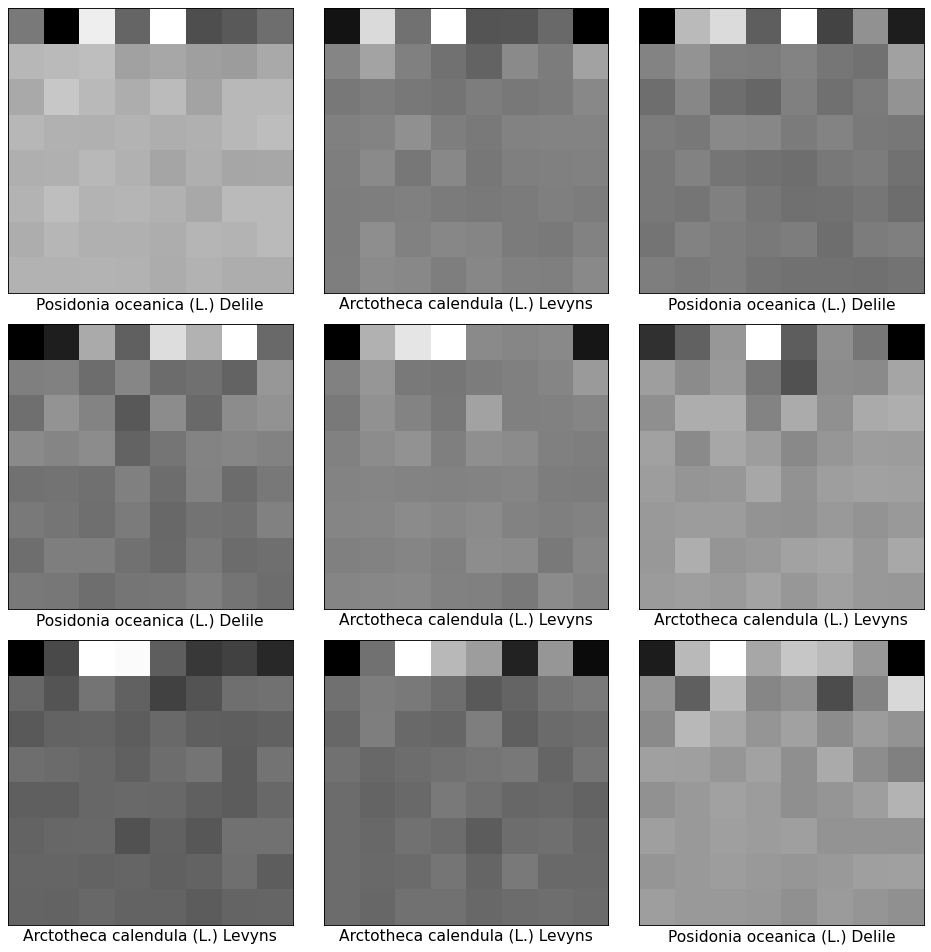

In [8]:
# Plot DCT image embeddings
plot_images_from_embeddings(
    dct_joined_df, data_col="dct_embedding", image_col="binomial_name", grid_size=(3, 3)
)

### full-size train data

In [9]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-snakeclef-2024/data/process"
dino_emb_train = "training_cropped_resized_v2/dino/data"
dct_emb_train = "training_cropped_resized_v2/dino_dct/data"

# Define the GCS path to the embedding files
dino_gcs_path = f"{gcs_path}/{dino_emb_train}"
dct_gcs_path = f"{gcs_path}/{dct_emb_train}"

# Read the Parquet file into a DataFrame
dino_df = spark.read.parquet(dino_gcs_path)
dct_df = spark.read.parquet(dct_gcs_path)

# Show the data
dino_df.show(n=5, truncate=50)
dct_df.show(n=5, truncate=50)

+--------------------------------------------+----------+--------------------------------------------------+---------+
|                                  image_name|species_id|                                    dino_embedding|sample_id|
+--------------------------------------------+----------+--------------------------------------------------+---------+
|8384311a03a9cff67a54a2825dbeb4d3e8a891a3.jpg|   1397608|[0.75137013, 0.3275455, 1.6707572, 0.45285824, ...|        9|
|b38e87b2a2bcfeefcbc6adbeb4aad0437b9e1839.jpg|   1397608|[0.35812917, 1.4896353, 2.4680657, 0.7175607, 0...|        9|
|b56d8dc9553c1014cb6aecffa93c734aaa997ccf.jpg|   1363992|[1.5729619, -0.0512933, 0.5113419, -1.4510978, ...|        9|
|ff815358961d1c0dbd1a95e1ac5f9dff0e5e13fc.jpg|   1358357|[1.8277985, 0.011137103, -0.058480255, -0.32846...|        9|
|e2b977b6461d35a266c28806cb75e11930614866.jpg|   1363814|[0.37129048, -1.4583586, -3.1828911, 1.3645148,...|        9|
+--------------------------------------------+--

In [10]:
dino_count = dino_df.count()
dct_count = dct_df.count()

print(f"DINO count: {dino_count}")
print(f"DCT count:  {dct_count}")

DINO count: 1408033
DCT count:  1408033


In [11]:
dino_df.groupBy("sample_id").count().select("sample_id", "count").show()

+---------+------+
|sample_id| count|
+---------+------+
|        9|139429|
|        3|148106|
|        7|136313|
|        0|145868|
|        4|130862|
|        5|143432|
|        8|139638|
|        6|141458|
|        1|148260|
|        2|134667|
+---------+------+

